In [2]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-aer

In [4]:
from numpy import *
from matplotlib.pyplot import *
from scipy.ndimage import gaussian_filter1d

In [10]:
# Importing standard Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, noise, AerSimulator
from qiskit_aer.noise import depolarizing_error, NoiseModel, pauli_error
from qiskit.quantum_info import state_fidelity, Statevector, DensityMatrix, partial_trace

# from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_ibm_runtime import QiskitRuntimeService

# Loading your IBM Quantum account(s)
# provider = QiskitRuntimeService(channel="ibm_quantum_platform", token="786ab83c1f9b5535280b9414b2ba912efd79cf4264ccabab0982b47ca2fa4a9460f8994e175a00654be48b678cdbbb65d5a7276a8a0e36edbc761fcf22016aa6")

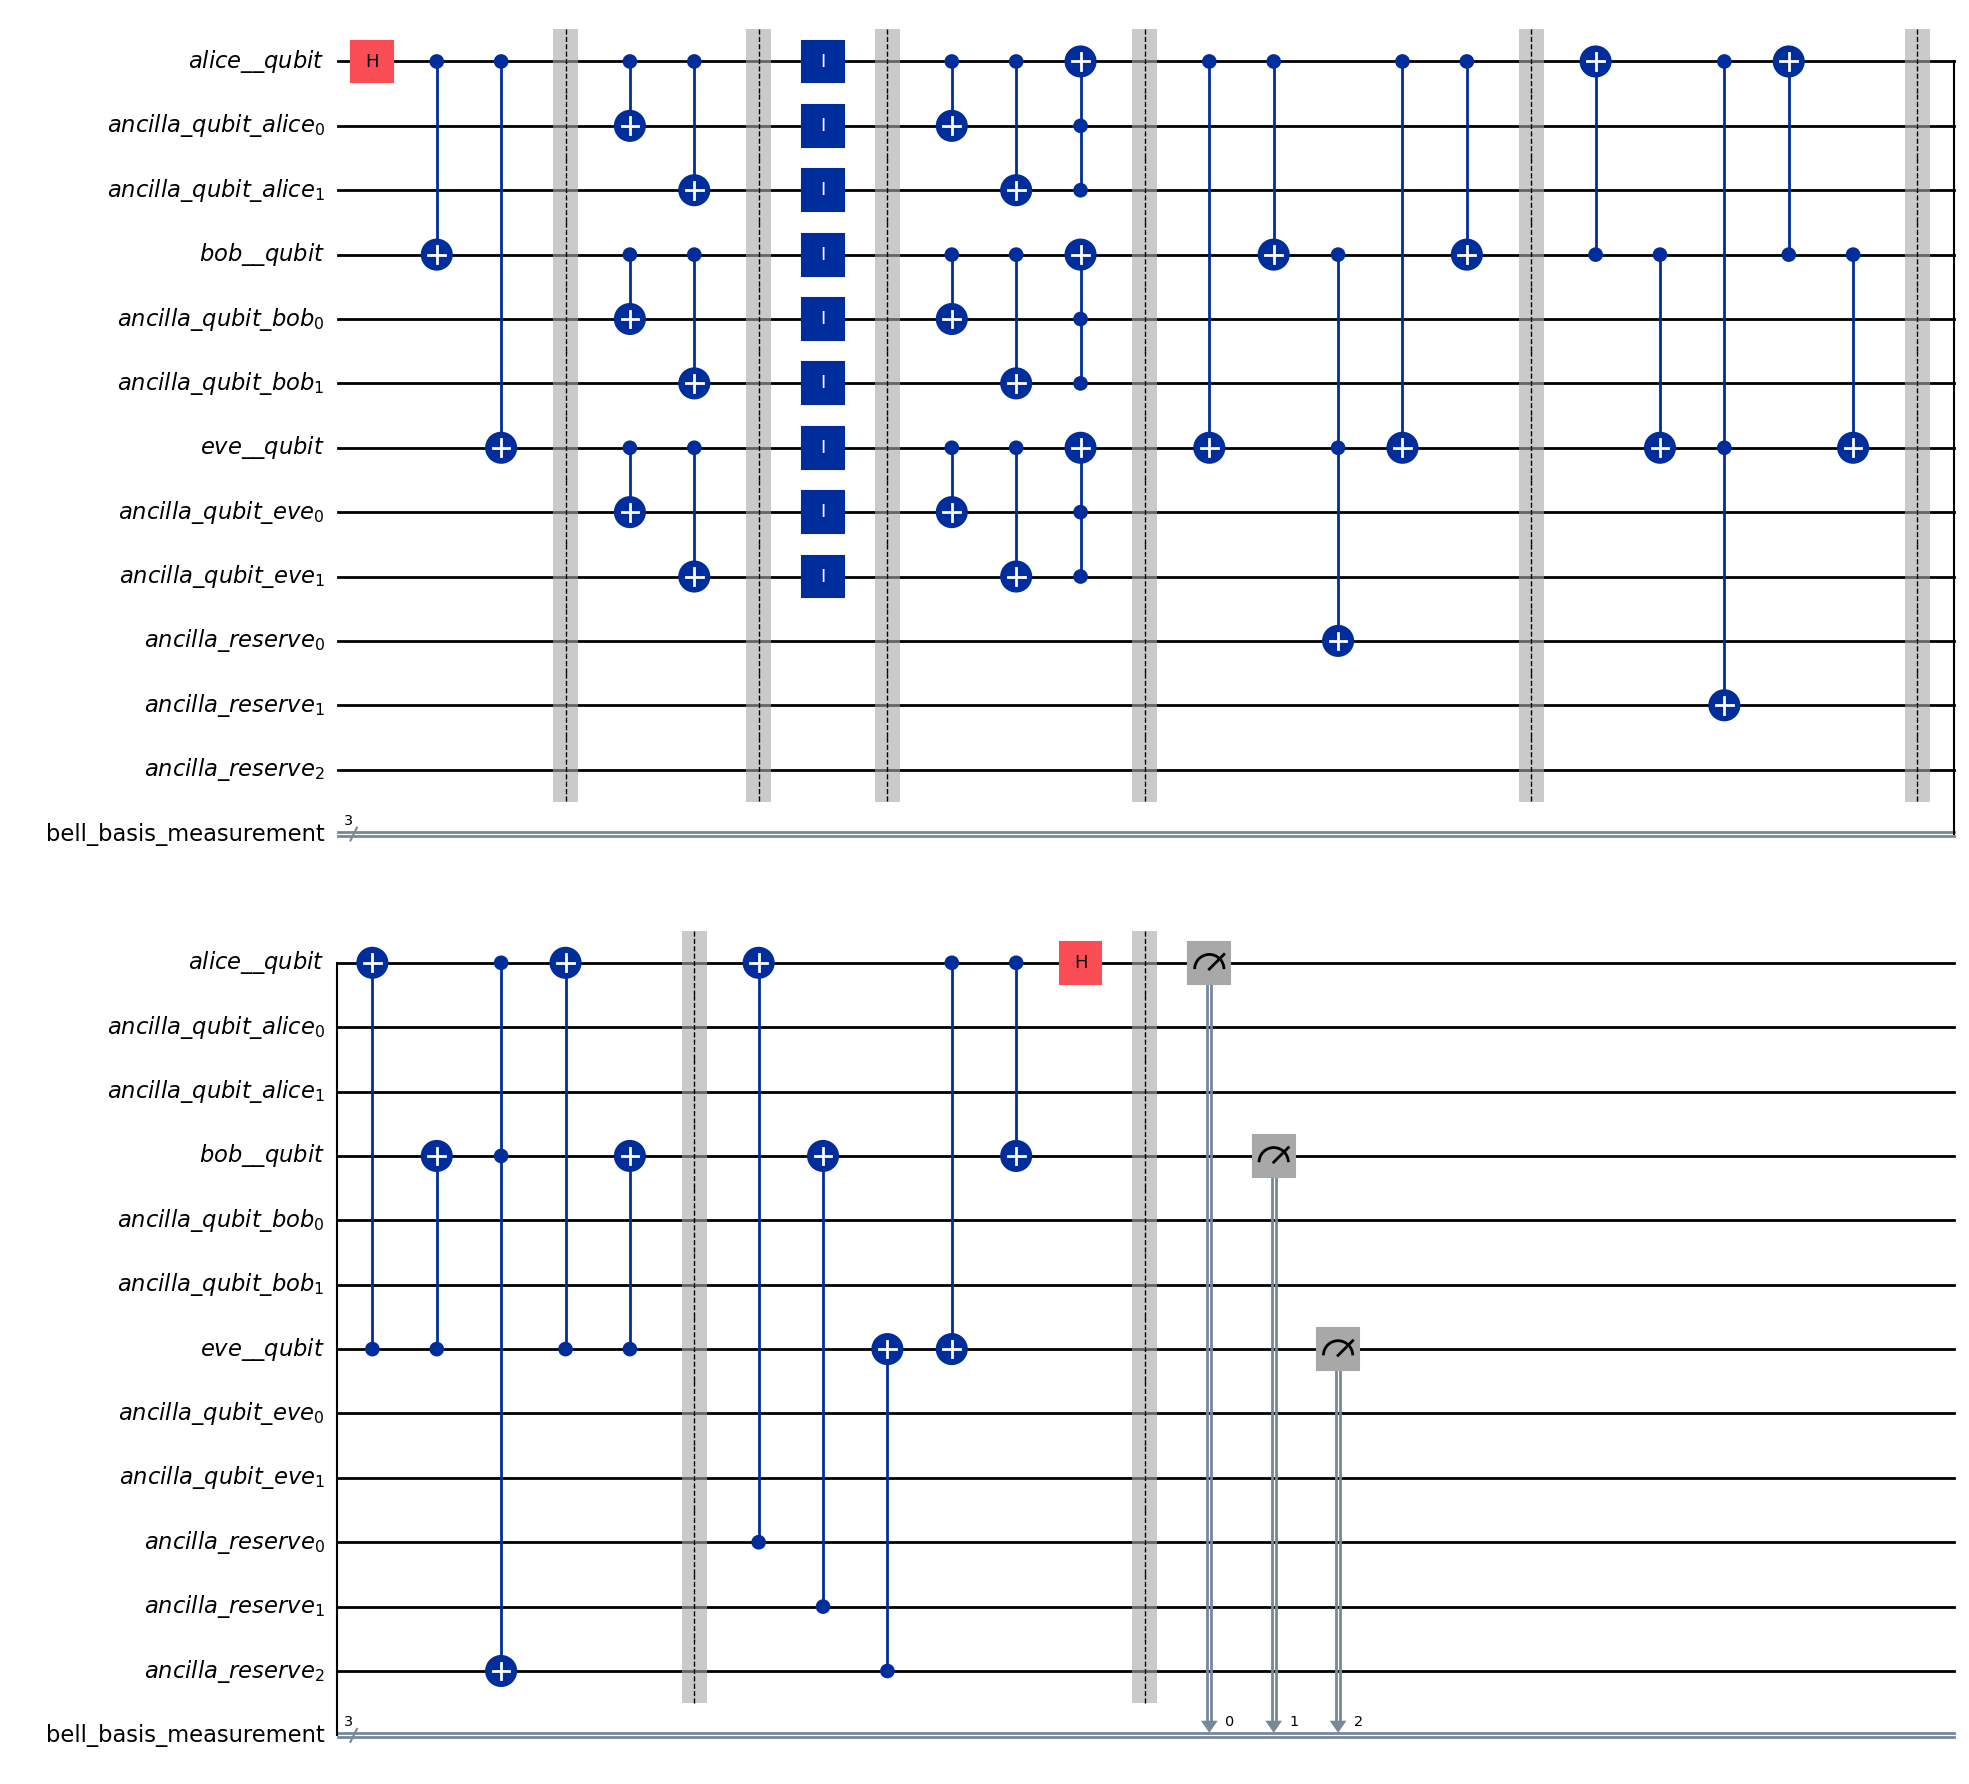

In [11]:
cr= ClassicalRegister(3,"bell_basis_measurement")
alice= QuantumRegister(1, 'alice__qubit')
bob= QuantumRegister(1, 'bob__qubit')
eve= QuantumRegister(1, 'eve__qubit')
aq1= QuantumRegister(2, 'ancilla_qubit_alice')
aq2= QuantumRegister(2,'ancilla_qubit_bob')
aq3= QuantumRegister(2,'ancilla_qubit_eve')
aq4= QuantumRegister(3,'ancilla_reserve')

repetition3 = QuantumCircuit(alice,aq1,bob,aq2,eve,aq3,aq4,cr)

repetition3.h(alice)
repetition3.cx(alice,bob)
repetition3.cx(alice,eve)

repetition3.barrier()
repetition3.cx(alice, aq1)
repetition3.cx(bob, aq2)
repetition3.cx(eve, aq3)

repetition3.barrier()

repetition3.id(range(repetition3.num_qubits-3))
repetition3.barrier()

repetition3.cx(alice, aq1)
repetition3.cx(bob, aq2)
repetition3.cx(eve, aq3)

repetition3.mcx([1,2],0)
repetition3.mcx([4,5],3)
repetition3.mcx([7,8],6)
repetition3.barrier()

repetition3.cx(alice,eve)
repetition3.cx(alice,bob)
repetition3.ccx(bob, eve, aq4[0])
repetition3.cx(alice,eve)
repetition3.cx(alice,bob)
repetition3.barrier()

repetition3.cx(bob,alice)
repetition3.cx(bob,eve)
repetition3.ccx(alice, eve, aq4[1])
repetition3.cx(bob,alice)
repetition3.cx(bob,eve)
repetition3.barrier()

repetition3.cx(eve,alice)
repetition3.cx(eve,bob)
repetition3.ccx(alice, bob, aq4[2])
repetition3.cx(eve,alice)
repetition3.cx(eve,bob)
repetition3.barrier()


repetition3.cx(aq4[0],alice)
repetition3.cx(aq4[1],bob)
repetition3.cx(aq4[2],eve)
repetition3.cx(alice,eve)
repetition3.cx(alice,bob)
repetition3.h(alice)
repetition3.barrier()

repetition3.measure([alice[0], bob[0], eve[0]],cr)
repetition3.draw(output='mpl')

In [ ]:
repetition3.draw(output='mpl').savefig("GHZ state simulation diagram.pdf",dpi=400,bbox_inches="tight")

In [14]:
# Range of noise levels for one-qubit gates
noise_prob = np.linspace(0,1,30)
# params = 4*noise_prob/3
fidelities3 = []

for rate in noise_prob:
    # Create a new noise model with varying one-qubit depolarizing noise
    noise_model = NoiseModel()
    bit_flip_error = pauli_error([('X',rate), ('I', 1-rate)])
    
    noise_model.add_all_qubit_quantum_error(bit_flip_error, 'id')
    
    simulator = AerSimulator(method='matrix_product_state')
    circuit = transpile(repetition3, simulator,optimization_level=0)

    # Get and print the result
    counts = simulator.run(circuit,noise_model=noise_model,shots=300).result().get_counts()
    
    # just taking 15 measurements and getting the average
    for i in range(14):
        count = simulator.run(circuit,noise_model=noise_model,shots=300).result().get_counts()
        counts = {key: count.get(key,0) + counts.get(key,0) for key in set(count) | set(counts)}

    counts = {key: counts[key] / 15 for key in counts}
    print(counts)
    probabilities = {key: count / 300 for key, count in counts.items()}
    
    # Calculate fidelity
    fidelity = probabilities['000']
    fidelities3.append(fidelity)

{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}
{'000': 300.0}


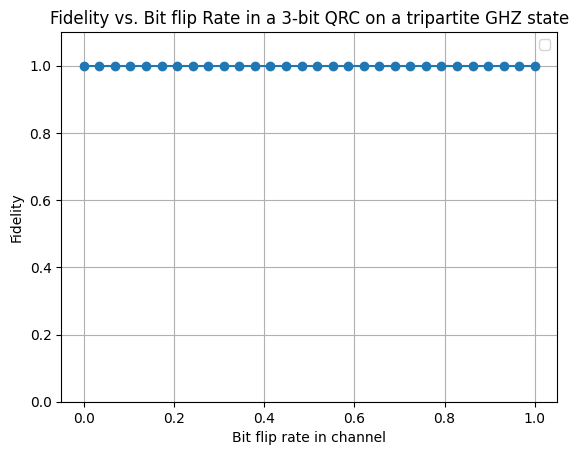

In [15]:
# Plot the fidelity graph
plot(noise_prob, gaussian_filter1d(fidelities3, sigma=1), marker='o')
xlabel('Bit flip rate in channel')
ylabel('Fidelity')
title('Fidelity vs. Bit flip Rate in a 3-bit QRC on a tripartite GHZ state')
ylim(0, 1.1)
grid()
legend()
savefig("Fidelity of GHZ state.pdf",dpi=400,bbox_inches="tight")